# Basic Idea

<b>We will create a semi-automatic algorithm that will alert to buy or sell in real-time.</br>
This will be done in 4 steps: </b></br>
1) Find 2 assets that move similarly with eachother over the past X periods of time. </br>
2) Calculate the ratio between them.</br>
3) Find the correct signal to buy or sell the assets, by their standard deviation from the mean.</br>
4) Alert buy / sell.

# Basic Concepts
<b>Let's go over some of the concpets we'll use in this project:</b></br>
1) <u>Cointegration:</u> Similar to correlation. Means that the ratio between two series will vary around a mean. </br>  The two series, Y and X follow the follwing: Y = ⍺ X + e where ⍺ is the constant ratio and e is white noise</br>
</br>
2) <u>Stationarity:</u> A stochastic process whose unconditional joint probability distribution does not change when shifted in time. (basically - not time dependant). </br>

# Project requirements

In [3]:
from asyncio import threads
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import yfinance as yf
from yahoo_fin.stock_info import get_data
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objs as go

# Data that will be used
We will examine ETFs of tech companies.</br>
Our assumption is that each of them is stationary, and that they will probably be cointegrated, or at least correlated. </br>
We will be looking at the following ETFs: </br>
* VGT
* XLK
* SMH
* SOXX
* IYW 

Which are the Top 5 ETFs considering total assets and 5 years look back window profits. ([etfdb](https://etfdb.com/etfdb-category/technology-equities/))

# Loading data

In [20]:
# Loading data for S&P 500 time-series
vgt = yf.Ticker('VGT')
xlk = yf.Ticker('XLK')
smh = yf.Ticker('SMH')
soxx = yf.Ticker('SOXX')
iyw = yf.Ticker('IYW')

data_hist = vgt.history(period='max')

# check for null and zero entries 
len(
  data_hist[
    data_hist.Close.isna() |
    data_hist.Close.isnull() |
    data_hist.Close < 1e-8
  ]
)
# Print data history
data_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-01-30,41.826805,42.255886,41.826805,42.118580,117600,0.0,0
2004-02-02,42.135741,42.152905,41.912620,42.152905,65400,0.0,0
2004-02-03,41.878302,41.895466,41.723833,41.895466,231100,0.0,0
2004-02-04,40.762690,40.762690,40.633965,40.633965,51000,0.0,0
2004-02-05,40.934318,40.934318,40.633960,40.839920,2600,0.0,0
...,...,...,...,...,...,...,...
2022-04-28,374.200012,385.390015,371.700012,383.130005,570500,0.0,0
2022-04-29,378.839996,384.220001,366.660004,367.200012,615200,0.0,0
2022-05-02,366.380005,373.600006,362.899994,373.269989,711700,0.0,0


# Calculate and plot ratio

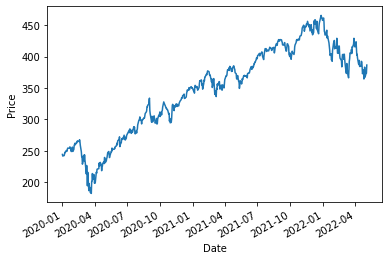

In [19]:
# Plotting prices
data.Close.plot()
plt.ylabel("Price");